In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

from utils.loss import DiceLoss, DiceCrossEntropyLoss
from utils.dataset import BrainMRISliceDataset
from utils.utils import train, validate
from utils.metric import MetricsMonitor
from utils.vis import plot_mri

/root/miniconda3/envs/py11/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Constants

In [4]:
ROOT_DIR = './Data/'
BATCH_SIZE = 16
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 0
LR = 0.01

## Transforms

In [5]:
train_transform = A.Compose([
    # A.Resize(256, 256),  # Resize both image and mask
    # A.HorizontalFlip(p=0.5),  # Flip horizontally
    # A.VerticalFlip(p=0.5),  # Flip vertically
    # A.RandomRotate90(p=0.5),  # Randomly rotate 90 degrees
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),  
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(normalization="min_max", p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize the image
    ToTensorV2()  # Convert to PyTorch tensors
], additional_targets={'mask': 'mask'})  # Specify the target name for the label

test_transform = A.Compose([
    # A.Resize(256, 256),
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(normalization="min_max", p=1.0),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [6]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=2, transform=train_transform, num_classes=3, cache=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, num_classes=3, cache=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

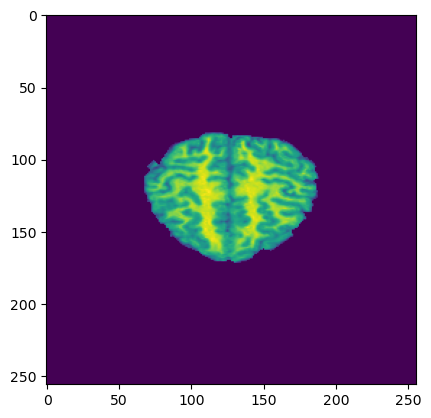

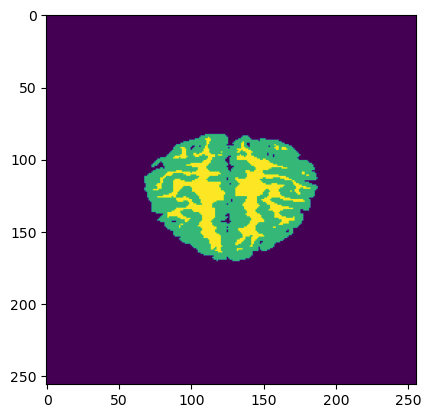

tensor(0.) tensor(1.)


In [7]:
image, mask = val_dataset[180]
plt.imshow(image.permute(2, 1, 0).numpy())
plt.show()

plt.imshow(mask.permute(2, 1, 0).numpy())
plt.show()
print (image.min(), image.max())

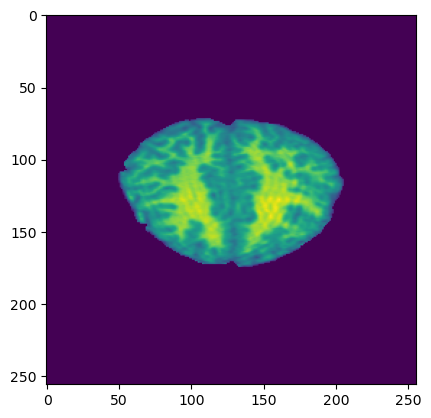

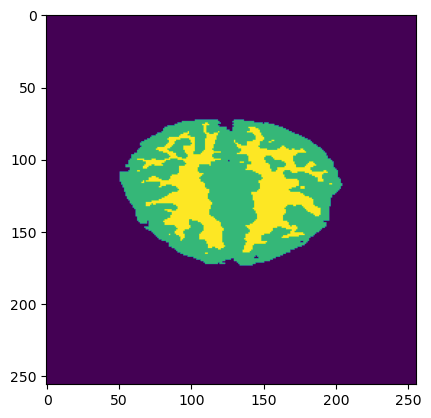

tensor(0.) tensor(1.)


In [8]:
image, mask = train_dataset[180]
plt.imshow(image.permute(2, 1, 0).numpy())
plt.show()

plt.imshow(mask.permute(2, 1, 0).numpy())
plt.show()
print (image.min(), image.max())

## Models

In [25]:
model = smp.Unet(
    encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:11<00:00, 22.9MB/s] 


## Loss & Optimizer

In [26]:
# criteria =  torch.nn.CrossEntropyLoss(ignore_index=0)
# criteria = torch.nn.BCEWithLogitsLoss()
criteria = DiceCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.01)

## Training

In [27]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "dice_score"])

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criteria, optimizer, DEVICE, train_monitor)
    scheduler.step()
    validate(model, val_loader, criteria, DEVICE, val_monitor)

Epoch 1/300
----------
[Train] Iteration 1/160 - loss: 1.3199, dice_score: 0.1007

[Train] Iteration 160/160 - loss: 0.3110, dice_score: 0.4419
Train Metrics - loss: 0.3110, dice_score: 0.4419
[Validation] Iteration 80/80 - loss: 0.3912, dice_score: 0.3330
Validation Metrics - loss: 0.3912, dice_score: 0.3330
Epoch 2/300
----------
[Train] Iteration 160/160 - loss: 0.2637, dice_score: 0.5040
Train Metrics - loss: 0.2637, dice_score: 0.5040
[Validation] Iteration 80/80 - loss: 0.4863, dice_score: 0.3185
Validation Metrics - loss: 0.4863, dice_score: 0.3185
Epoch 3/300
----------
[Train] Iteration 160/160 - loss: 0.2538, dice_score: 0.5201
Train Metrics - loss: 0.2538, dice_score: 0.5201
[Validation] Iteration 80/80 - loss: 0.2801, dice_score: 0.4877
Validation Metrics - loss: 0.2801, dice_score: 0.4877
Epoch 4/300
----------
[Train] Iteration 160/160 - loss: 0.2484, dice_score: 0.5288
Train Metrics - loss: 0.2484, dice_score: 0.5288
[Validation] Iteration 80/80 - loss: 0.2534, dice_score: 0.5188
Validation Metrics - loss: 0.2534, dice_score: 0.5188
Epoch 5/300
-------

## Predict

In [ ]:
model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(val_loader):
        if batch_idx == 10:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.cpu().numpy()
            outputs = outputs.argmax(axis=1)
            break

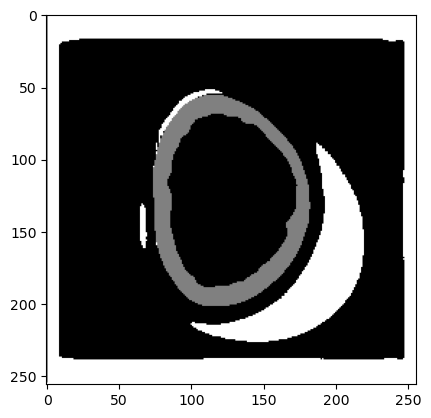

In [ ]:
plt.imshow(outputs[15], cmap='gray')

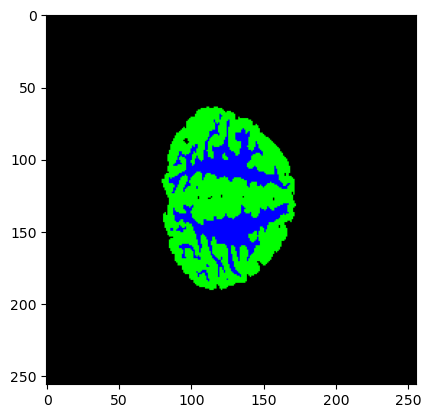

In [ ]:
plt.imshow(masks[15].permute(1, 2, 0).cpu().numpy(),  cmap='gray')